In [1]:
import pandas as pd
import numpy as np
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")

In [2]:
#loading of the data
data=pd.read_csv("Train.csv")

In [3]:
#gives the First 5 rows
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
data.shape

(8523, 12)

In [5]:
data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [6]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [7]:
print(data.isnull().sum())

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [8]:
non_zero_mean = data.loc[data['Item_Visibility'] > 0, 'Item_Visibility'].mean()

In [9]:
data['Item_Weight'] = data['Item_Weight'].fillna(data.groupby('Item_Type')['Item_Weight'].transform('median'))

In [10]:
# Filling missing 'Outlet_Size' with the mode of each 'Outlet_Type' group.
data['Outlet_Size'] = data['Outlet_Size'].fillna(
    data.groupby('Outlet_Type')['Outlet_Size']
    .transform(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown')
)

In [11]:
#Feature Encoding
data.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat','reg':'Regular'}},inplace=True)
data['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

In [12]:
data.drop_duplicates(inplace=True)

In [13]:
print(data.isnull().sum())

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64


# EDA
This file goal is to do EDA before that Data cleaning is done

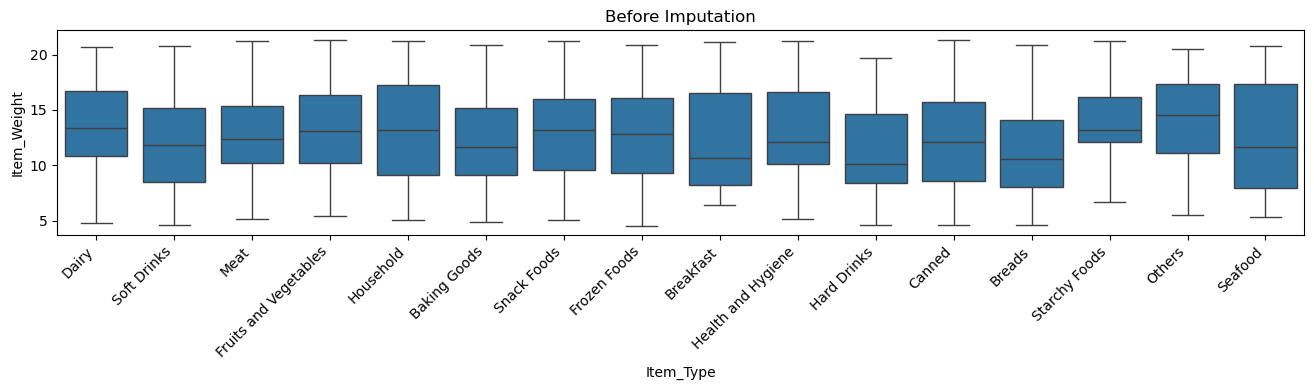

In [15]:
plt.figure(figsize=(26, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x='Item_Type', y='Item_Weight', data=data[data['Item_Weight'].notnull()])
plt.title('Before Imputation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

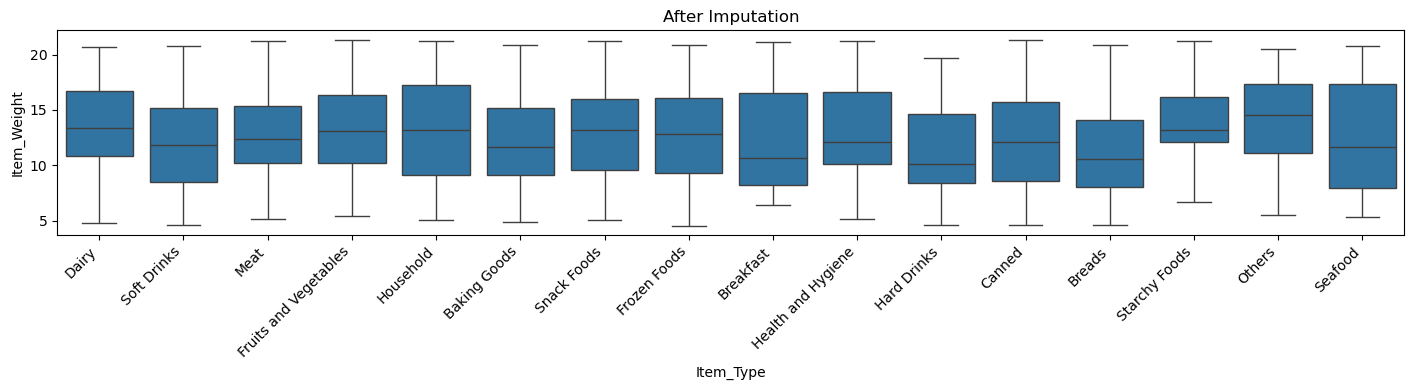

In [16]:
plt.figure(figsize=(28, 4))
plt.subplot(1, 2, 2)
sns.boxplot(x='Item_Type', y='Item_Weight', data=data)
plt.title('After Imputation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjusts layout to prevent overlap
plt.show()

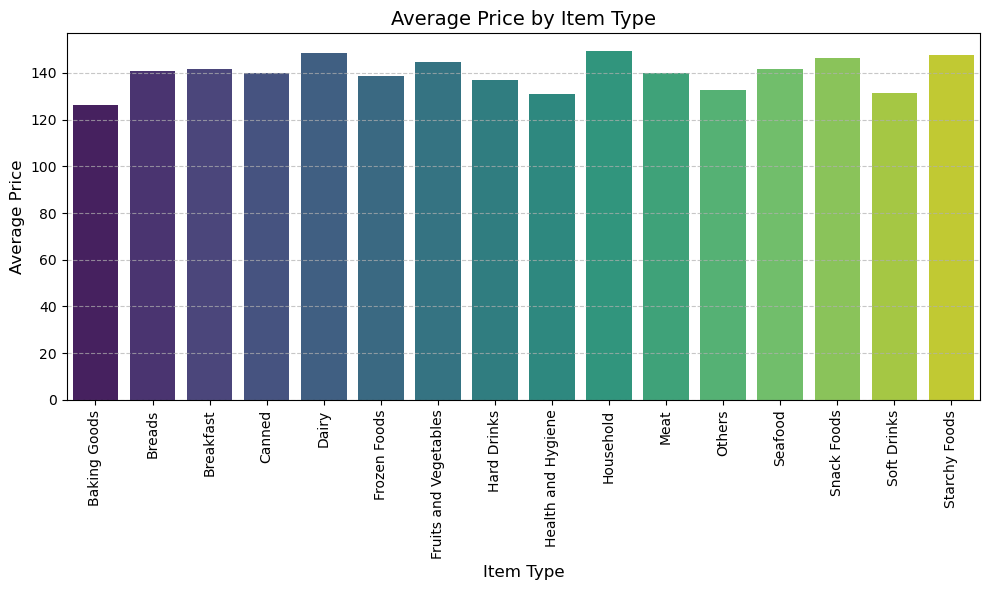

In [17]:
# Calculate average price by Item Type
item_avg_price = data.groupby('Item_Type')['Item_MRP'].mean()

# Visualization: Bar Plot for Average Price by Item Type
plt.figure(figsize=(10, 6))
sns.barplot(x=item_avg_price.index, y=item_avg_price.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Average Price by Item Type', fontsize=14)
plt.xlabel('Item Type', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


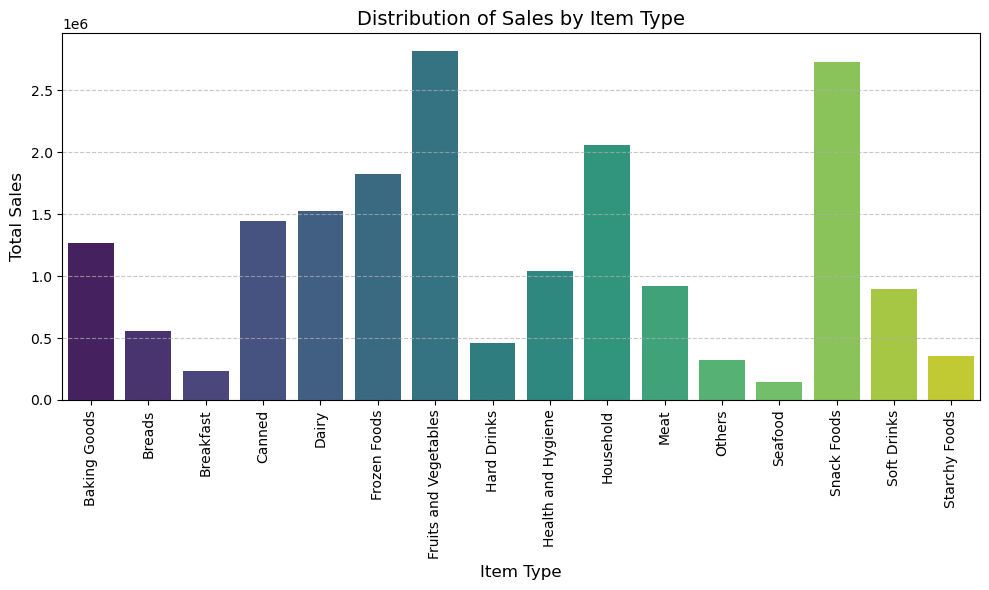

In [18]:
# Calculate total sales by Item Type
item_sales = data.groupby('Item_Type')['Item_Outlet_Sales'].sum()

# Visualization: Bar Plot for Distribution of Sales by Item Type
plt.figure(figsize=(10, 6))
sns.barplot(x=item_sales.index, y=item_sales.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Distribution of Sales by Item Type', fontsize=14)
plt.xlabel('Item Type', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [19]:
data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [20]:
# Observation for Task 1: Identifying the item type with the highest sales
top_item_type = item_sales.idxmax()  # Item type with the highest sales
top_sales_value = item_sales.max()   # Highest sales value

print(f"Observation: The item type '{top_item_type}' generates the highest sales with a total of {top_sales_value:.2f}.")


Observation: The item type 'Fruits and Vegetables' generates the highest sales with a total of 2820059.82.


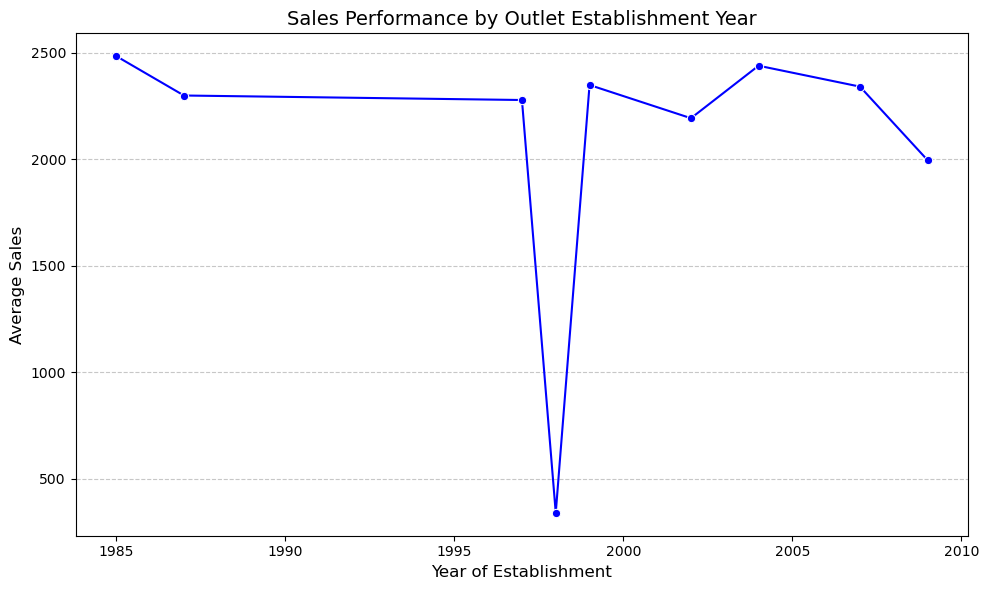

In [21]:
# Calculate average sales by Outlet Establishment Year
yearly_sales = data.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].mean()

# Visualization: Line Plot for Sales Performance by Outlet Establishment Year
plt.figure(figsize=(10, 6))
sns.lineplot(x=yearly_sales.index, y=yearly_sales.values, marker='o', color='blue')
plt.title('Sales Performance by Outlet Establishment Year', fontsize=14)
plt.xlabel('Year of Establishment', fontsize=12)
plt.ylabel('Average Sales', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [22]:
# Observation for Task 2: Sales variation by Outlet Establishment Year
best_year = yearly_sales.idxmax()  # Year with the highest average sales
highest_avg_sales = yearly_sales.max()  # Highest average sales value

print(f"Observation: Outlets established in the year '{best_year}' have the highest average sales, with an average sales value of {highest_avg_sales:.2f}.")


Observation: Outlets established in the year '1985' have the highest average sales, with an average sales value of 2483.68.


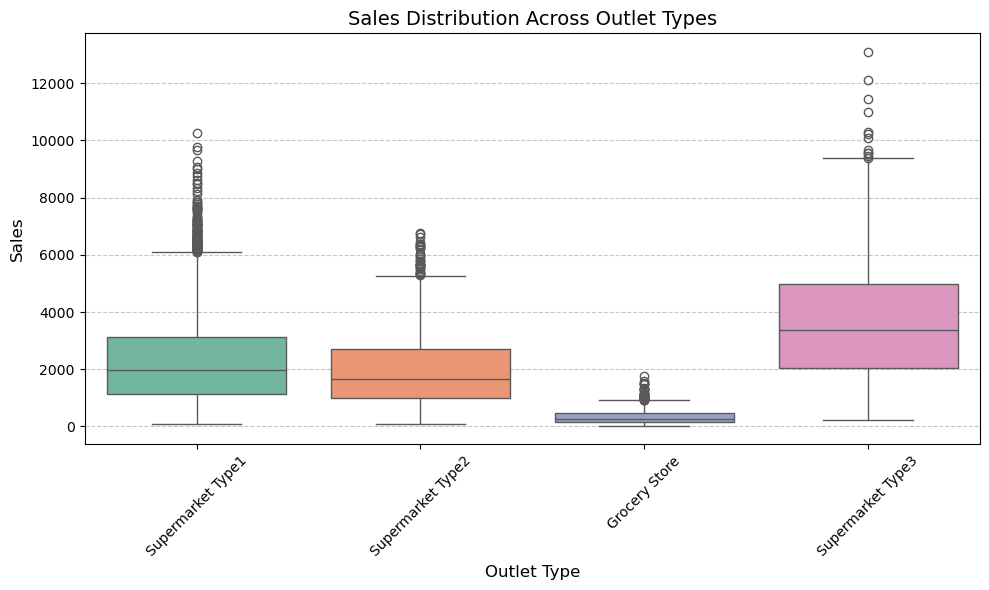

In [23]:
# Visualization: Box Plot for Sales Distribution Across Outlet Types
plt.figure(figsize=(10, 6))
sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data=data, palette='Set2')
plt.title('Sales Distribution Across Outlet Types', fontsize=14)
plt.xlabel('Outlet Type', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional grid for better readability
plt.tight_layout()
plt.show()


In [24]:
# Observation for Task 3: Outlet type with the highest sales distribution
most_sales_outlet_type = data.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().idxmax()
highest_avg_sales = data.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().max()

print(f"Observation: '{most_sales_outlet_type}' outlets have the highest average sales, with an average sales value of {highest_avg_sales:.2f}.")


Observation: 'Supermarket Type3' outlets have the highest average sales, with an average sales value of 3694.04.


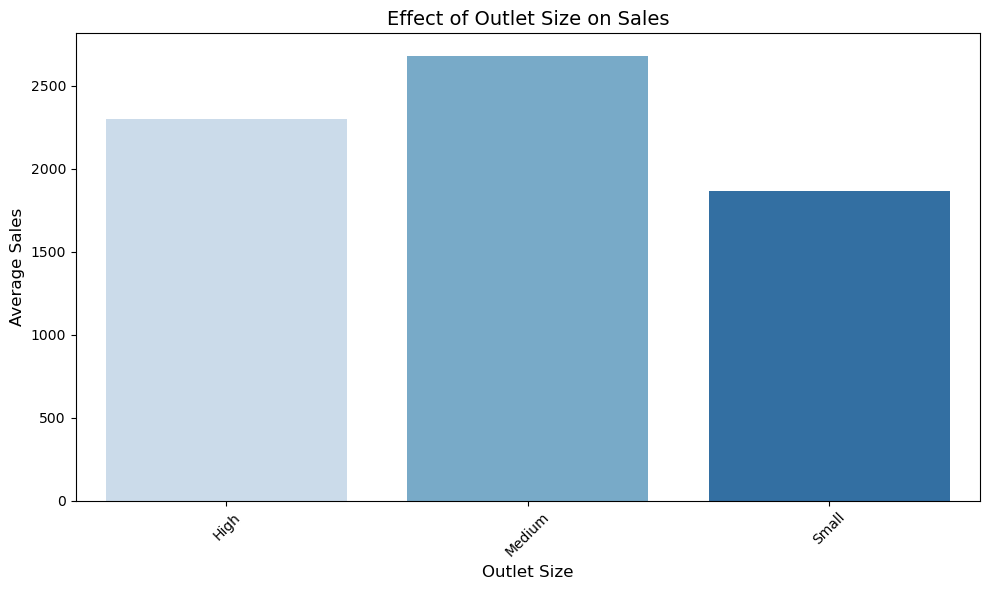

In [25]:
# Calculate average sales by Outlet Size
size_sales = data.groupby('Outlet_Size')['Item_Outlet_Sales'].mean()

# Visualization: Bar Plot for Effect of Outlet Size on Sales
plt.figure(figsize=(10, 6))
sns.barplot(x=size_sales.index, y=size_sales.values, palette='Blues')
plt.title('Effect of Outlet Size on Sales', fontsize=14)
plt.xlabel('Outlet Size', fontsize=12)
plt.ylabel('Average Sales', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.tight_layout()
plt.show()


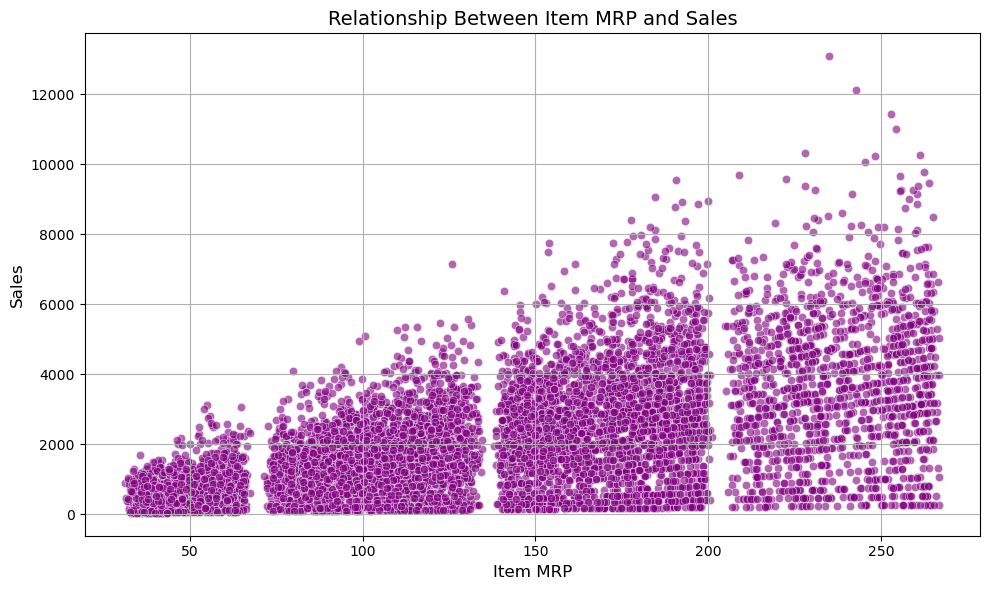

In [26]:
# Visualization: Scatter Plot for Relationship Between Item MRP and Sales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Item_MRP', y='Item_Outlet_Sales', data=data, color='purple', alpha=0.6)
plt.title('Relationship Between Item MRP and Sales', fontsize=14)
plt.xlabel('Item MRP', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
# Observation for Task 4: Observing how outlet size impacts sales
top_outlet_size = size_sales.idxmax()  # Outlet size with the highest average sales
highest_avg_sales_size = size_sales.max()  # Highest average sales value

print(f"Observation: Large outlets generate the highest average sales, with '{top_outlet_size}' size outlets performing best, achieving an average sales value of {highest_avg_sales_size:.2f}.")


Observation: Large outlets generate the highest average sales, with 'Medium' size outlets performing best, achieving an average sales value of 2681.60.


In [28]:
top_performers = data.groupby('Item_Type')['Item_Outlet_Sales'].sum().reset_index()

In [29]:
top_performers = top_performers.sort_values(by='Item_Outlet_Sales', ascending=False)

In [30]:
top_n = top_performers.head(5)  # Change the number to however many top performers you want
print(top_n)

                Item_Type  Item_Outlet_Sales
6   Fruits and Vegetables       2.820060e+06
13            Snack Foods       2.732786e+06
9               Household       2.055494e+06
5            Frozen Foods       1.825735e+06
4                   Dairy       1.522594e+06


## Feature Derivation

In [32]:
# Creating a new column 'Outlet_age' to calculate the store's age based on its establishment year
data['Outlet_age'] = 2024 - data['Outlet_Establishment_Year']
# Deriving a new feature: 'sales_per_mrp' by dividing Item_Outlet_Sales by Item_MRP
# This step handles potential division by zero by replacing zero values with 1
data['sales_per_mrp'] = data['Item_Outlet_Sales'] / data['Item_MRP'].replace(0, 1)  # Replace 0 with 1 to avoid division by zero
# Printing relevant columns to verify
print(data[['Outlet_Establishment_Year', 'Outlet_age', 'Item_Outlet_Sales', 'Item_MRP', 'sales_per_mrp']].head())

   Outlet_Establishment_Year  Outlet_age  Item_Outlet_Sales  Item_MRP  \
0                       1999          25          3735.1380  249.8092   
1                       2009          15           443.4228   48.2692   
2                       1999          25          2097.2700  141.6180   
3                       1998          26           732.3800  182.0950   
4                       1987          37           994.7052   53.8614   

   sales_per_mrp  
0      14.951963  
1       9.186454  
2      14.809346  
3       4.021967  
4      18.467868  


In [33]:
data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Outlet_age', 'sales_per_mrp'],
      dtype='object')

In [34]:
rows, columns = data.shape
print("Total number of rows:", rows)
print("Total number of columns:", columns)

Total number of rows: 8523
Total number of columns: 14


##  Categorical Variable Encoding

In [36]:
# Columns with high cardinality
high_cardinality_columns = ['Item_Identifier', 'Outlet_Identifier']
target_encoder = TargetEncoder(cols=high_cardinality_columns)
data = target_encoder.fit_transform(data, data['Item_Outlet_Sales'])
# Identifying categorical and numerical columns for encoding and scaling
nominal_columns = ['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type']
ordinal_columns = ['Outlet_Size']
numerical_columns = ['Item_Weight', 'Item_Visibility', 'Item_MRP']
print("Nominal Columns: ", nominal_columns)
print("Ordinal Columns: ", ordinal_columns)
print("Numerical Columns: ", numerical_columns)

Nominal Columns:  ['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type']
Ordinal Columns:  ['Outlet_Size']
Numerical Columns:  ['Item_Weight', 'Item_Visibility', 'Item_MRP']


In [37]:
Outlet_Size_mapping = ['Small', 'Medium', 'High'] 

In [38]:
ohe = OneHotEncoder(drop='first', sparse_output=False)  # For nominal columns
ode = OrdinalEncoder(categories=[Outlet_Size_mapping])  # For ordinal column
scaler = StandardScaler()  # For numeric columns

In [39]:
ct = make_column_transformer(
    (ohe, nominal_columns),  # Nominal columns
    (ode, ordinal_columns),  # Ordinal column
    (scaler, numerical_columns),  # Numeric columns
    remainder='passthrough'
)
ct.set_output(transform='pandas')  
data_encoded = ct.fit_transform(data) 

In [40]:
# Cleaning up column names to remove the transformer prefix
data_encoded.columns = [col.replace("onehotencoder__", "")
                             .replace("ordinalencoder__", "")
                             .replace("standardscaler__", "")
                             .replace("remainder__","")
                             for col in data_encoded.columns]
print("Encoded Columns:\n", data_encoded.columns.tolist())

Encoded Columns:
 ['Item_Fat_Content_Regular', 'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods', 'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods', 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3', 'Outlet_Size', 'Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year', 'Item_Outlet_Sales', 'Outlet_age', 'sales_per_mrp']


In [41]:
data_encoded.columns

Index(['Item_Fat_Content_Regular', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3', 'Outlet_Size', 'Item_Weight',
       'Item_Visibility', 'Item_MRP', 'Item_Identifier', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales', 'Outlet_age',
       'sales_per_mrp'],
      dtype='object')

In [42]:
rows, columns = data_encoded.shape
print("Total number of rows after encoding:", rows)
print("Total number of columns after encoding:", columns)

Total number of rows after encoding: 8523
Total number of columns after encoding: 31


## OUTLIER TREATMENT

In [44]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]
numerical_cols = ['Item_Weight','Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']
outliers = {}
for col in numerical_cols:
    outliers[col] = detect_outliers_iqr(data, col)
    print(f"Outliers detected in {col}: {len(outliers[col])}")

Outliers detected in Item_Weight: 0
Outliers detected in Item_Visibility: 144
Outliers detected in Item_MRP: 0
Outliers detected in Outlet_Establishment_Year: 0
Outliers detected in Item_Outlet_Sales: 186


In [45]:
# Define the columns with detected outliers
columns_with_outliers = ['Item_Visibility', 'Item_Outlet_Sales']
# Z-score threshold for capping
z_threshold = 3  # You can adjust this threshold if necessary
for col in columns_with_outliers:
    # Calculate the upper and lower bounds for capping
    upper_bound = data[col].mean() + z_threshold * data[col].std()
    lower_bound = data[col].mean() - z_threshold * data[col].std()
    # Cap the values in the column that are outside the bounds
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)
# Check if the outliers were capped
print("Outliers capped in columns:", columns_with_outliers)

Outliers capped in columns: ['Item_Visibility', 'Item_Outlet_Sales']


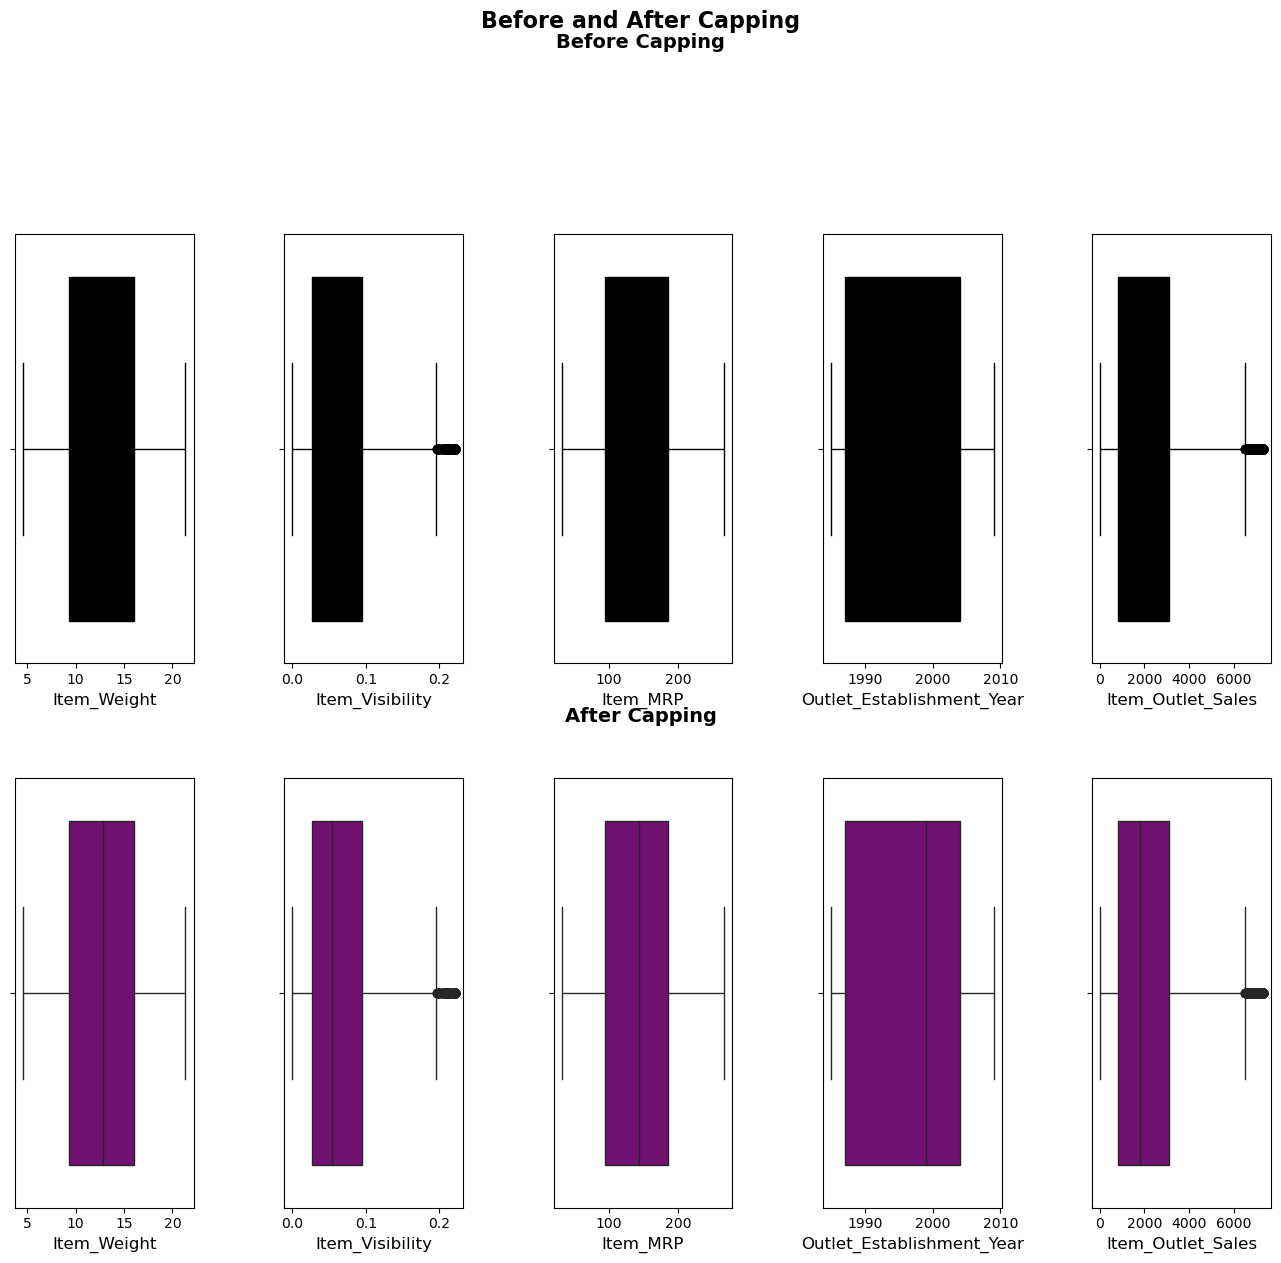

In [46]:
# Function to plot outliers comparison: before and after capping
def plot_outliers_comparison(data, numerical_cols):
    n_cols = len(numerical_cols)
    plt.figure(figsize=(14, n_cols * 2.5))  # Slightly reduced height
    # Plotting before capping
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(2, n_cols, i)  # Creating subplots for before capping
        sns.boxplot(data=data, x=col, color='black')
        plt.xlabel(col, fontsize=12)
    # Plotting after capping
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(2, n_cols, i + n_cols)  # Creating subplots for after capping
        sns.boxplot(data=data, x=col, color='purple')
        plt.xlabel(col, fontsize=12)
    # Title for both "Before" and "After" sections
    plt.suptitle("Before and After Capping", fontsize=16, weight='bold', y=1.05)
    # Titles for individual sections
    plt.figtext(0.5, 1.02, "Before Capping", fontsize=14, ha='center', weight='bold')
    plt.figtext(0.5, 0.48, "After Capping", fontsize=14, ha='center', weight='bold')  # Adjusted y position
    plt.tight_layout(pad=5.0)  # Increased padding between plots for more space
    plt.show()
# Call the function to plot before and after capping
plot_outliers_comparison(data, numerical_cols)

#### Most Notable Changes:
Item_Outlet_Sales: Major reduction in extreme high values
Item_MRP: Better controlled price range
Item_Visibility: Reduced unusually high visibility values

### FEATURE SCALING

In [49]:
min_max_scaler = MinMaxScaler()  # Initializing Min-Max Scaler
data_encoded[['Item_MRP', 'Item_Visibility']] = min_max_scaler.fit_transform(data_encoded[['Item_MRP', 'Item_Visibility']])
# Displaying the scaled data
data_encoded[['Item_MRP', 'Item_Visibility']].head()  # Checking the scaled values for 'Item_MRP' and 'Item_Visibility'

,Item_MRP,Item_Visibility
0,0.927507,0.048866
1,0.072068,0.058705
2,0.468288,0.051037
3,0.640093,0.000000
4,0.095805,0.000000


In [50]:
print(data_encoded[['Item_MRP', 'Item_Visibility']].skew())

Item_MRP           0.127202
Item_Visibility    1.167091
dtype: float64


In [51]:
print(data_encoded[['Item_MRP', 'Item_Visibility']].skew())


Item_MRP           0.127202
Item_Visibility    1.167091
dtype: float64


####  it indicates that both features have been sufficiently normalized or transformed. The values are very close to zero, which is ideal for most machine learning models, as they tend to perform better when the features are not highly skewed.

In [53]:
X = data.drop('Item_Outlet_Sales', axis=1)  # Features
y = data['Item_Outlet_Sales']  # Target

In [54]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
print(data_encoded.columns)

Index(['Item_Fat_Content_Regular', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3', 'Outlet_Size', 'Item_Weight',
       'Item_Visibility', 'Item_MRP', 'Item_Identifier', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales', 'Outlet_age',
       'sales_per_mrp'],
      dtype='object')


In [56]:
# List of categorical columns to encode
categorical_cols = ['Item_Fat_Content', 'Item_Identifier', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
# Label encoding categorical features
label_encoder = LabelEncoder()
for col in categorical_cols:
    if col in data_encoded.columns:
        data_encoded[col] = label_encoder.fit_transform(data_encoded[col])
X = data_encoded.drop(columns='Item_Outlet_Sales')
y = data_encoded['Item_Outlet_Sales']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Using RandomForestRegressor to determine feature importance
feature_selector = RandomForestRegressor(n_estimators=100, random_state=42)
feature_selector.fit(x_train, y_train)
# Selecting the top 10 important features based on feature importance scores
feature_importances = pd.Series(feature_selector.feature_importances_, index=X.columns)
top_features = feature_importances.nlargest(10).index
# Creating new datasets based on top 10 important features
X_top = X[top_features]
x_train, x_test = x_train[top_features], x_test[top_features]
print("Top 10 important features:\n", top_features)

Top 10 important features:
 Index(['sales_per_mrp', 'Item_MRP', 'Item_Identifier', 'Item_Visibility',
       'Item_Weight', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_age', 'Item_Type_Household', 'Item_Fat_Content_Regular'],
      dtype='object')


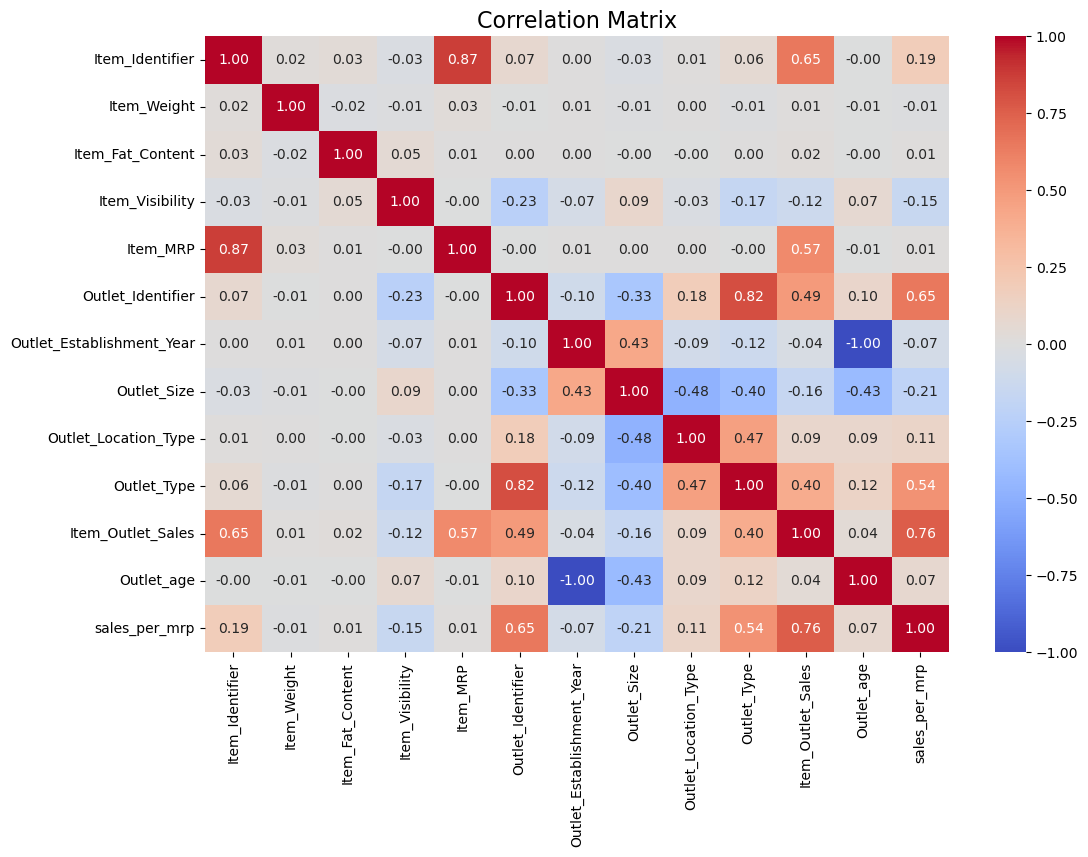

In [84]:
label_encoder = LabelEncoder()
categorical_columns = ['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']  # Add any other categorical columns here
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])
# Select only numeric columns for the correlation matrix
numeric_data = data.select_dtypes(include=['number'])
# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

## Modeling

In [86]:
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression": make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    "Decision Tree": DecisionTreeRegressor(random_state=2),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regression": make_pipeline(StandardScaler(), SVR(kernel='linear')),
    "KNN Regression": KNeighborsRegressor(n_neighbors=5),
    "XGBoost Regression": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, verbosity=0),
}

# Setting up to perform repeated train-test splits for model stability
n_runs = 10
results = {}

# Loop for each model evaluation
for model_name, model in models.items():
    test_r2_scores = []
    
    # Repeating train-test split for stability in R² scores
    for i in range(n_runs):
        x_train, x_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=i)
        
        model.fit(x_train, y_train)
        y_test_pred = model.predict(x_test)
       
        test_r2 = r2_score(y_test, y_test_pred)
        test_r2_scores.append(test_r2)
    
    mean_r2 = np.mean(test_r2_scores)
    std_dev_r2 = np.std(test_r2_scores)
    
    results[model_name] = {
        "Mean Test R2": mean_r2,
        "Standard Deviation of Test R2": std_dev_r2
    }
    
    print(f"\n--- {model_name} ---")
    print(f"Mean Test R2: {results[model_name]['Mean Test R2']}")
    print(f"Standard Deviation of Test R2: {results[model_name]['Standard Deviation of Test R2']}")


--- Linear Regression ---
Mean Test R2: 0.8880929012120843
Standard Deviation of Test R2: 0.006171726023882206

--- Polynomial Regression ---
Mean Test R2: 1.0
Standard Deviation of Test R2: 0.0

--- Decision Tree ---
Mean Test R2: 0.995853976274695
Standard Deviation of Test R2: 0.0012708570671716608

--- Random Forest ---
Mean Test R2: 0.998403389030077
Standard Deviation of Test R2: 0.0007905155149148597

--- Support Vector Regression ---
Mean Test R2: 0.8694654552726293
Standard Deviation of Test R2: 0.004797665704216891

--- KNN Regression ---
Mean Test R2: 0.891944729593716
Standard Deviation of Test R2: 0.0034108613131534774

--- XGBoost Regression ---
Mean Test R2: 0.9970922554826741
Standard Deviation of Test R2: 0.0005405026218729558


In [88]:
# Find the model with the highest Mean Test R² score but doesn't exceed 1.0
best_model_name = max(
    (name for name in results if results[name]['Mean Test R2'] < 1.0),
    key=lambda x: results[x]['Mean Test R2']
)
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name} with Mean Test R2: {results[best_model_name]['Mean Test R2']} and Standard Deviation of Test R2: {results[best_model_name]['Standard Deviation of Test R2']}")


Best Model: Random Forest with Mean Test R2: 0.998403389030077 and Standard Deviation of Test R2: 0.0007905155149148597


In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Initialize Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Single train-test split
x_train, x_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Fit the model
rf.fit(x_train, y_train)

# Predict on test data
y_test_pred = rf.predict(x_test)
test_r2 = r2_score(y_test, y_test_pred)

# Predict on train data
y_train_pred = rf.predict(x_train)
train_r2 = r2_score(y_train, y_train_pred)

# Print the results
print(f"--- Random Forest ---")
print(f"Test R2: {test_r2}")
print(f"Train R2: {train_r2}")


--- Random Forest ---
Test R2: 0.9985381437855677
Train R2: 0.9998370858954849


#### The small difference between the training and testing R² values suggests that your model is not overfitting and is generalizing well to new data.
 seems like a perfect result for your Random Forest model!

In [96]:
from sklearn.metrics import mean_squared_error, r2_score

# Assuming `X_test` contains the test features and `y_test` contains actual sales_per_mrp
y_pred = model.predict(x_test)  # Predicted values for sales_per_mrp

# Convert y_test to a single column if it's not already isolated
y_test = y_test['sales_per_mrp'] if isinstance(y_test, pd.DataFrame) else y_test

# Compare actual vs predicted in a DataFrame
comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Display the comparison
print(comparison.head())

# Optionally calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")


         Actual    Predicted
7503  1743.0644  1659.020630
2957   356.8688   368.531281
7031   377.5086   397.448425
1084  5778.4782  5828.791992
856   2356.9320  2486.519531
Mean Squared Error: 6207.832535758104
R2 Score: 0.9977160040826036


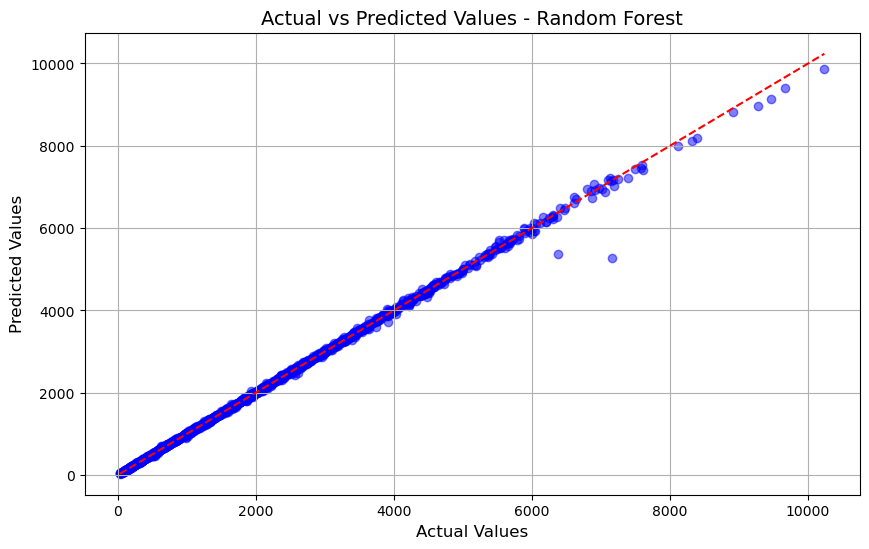

In [98]:
# Make predictions using the trained Random Forest model
y_pred = rf.predict(x_test)
# Plotting Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line of perfect prediction
plt.title('Actual vs Predicted Values - Random Forest', fontsize=14)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.grid(True)
plt.show()
